In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

## Loading the model

In [2]:
#!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [3]:
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [4]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))
for layer in layers:
    print(layer)

Number of layers 59
Total number of feature channels: 7548
import/conv2d0_pre_relu/conv
import/conv2d1_pre_relu/conv
import/conv2d2_pre_relu/conv
import/mixed3a_1x1_pre_relu/conv
import/mixed3a_3x3_bottleneck_pre_relu/conv
import/mixed3a_3x3_pre_relu/conv
import/mixed3a_5x5_bottleneck_pre_relu/conv
import/mixed3a_5x5_pre_relu/conv
import/mixed3a_pool_reduce_pre_relu/conv
import/mixed3b_1x1_pre_relu/conv
import/mixed3b_3x3_bottleneck_pre_relu/conv
import/mixed3b_3x3_pre_relu/conv
import/mixed3b_5x5_bottleneck_pre_relu/conv
import/mixed3b_5x5_pre_relu/conv
import/mixed3b_pool_reduce_pre_relu/conv
import/mixed4a_1x1_pre_relu/conv
import/mixed4a_3x3_bottleneck_pre_relu/conv
import/mixed4a_3x3_pre_relu/conv
import/mixed4a_5x5_bottleneck_pre_relu/conv
import/mixed4a_5x5_pre_relu/conv
import/mixed4a_pool_reduce_pre_relu/conv
import/mixed4b_1x1_pre_relu/conv
import/mixed4b_3x3_bottleneck_pre_relu/conv
import/mixed4b_3x3_pre_relu/conv
import/mixed4b_5x5_bottleneck_pre_relu/conv
import/mixed4b_5

In [5]:
# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

### Helper functions

In [23]:
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

### Helper functions for image processing

In [24]:
# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

## DeepDream algorithm

In [25]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

In [26]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)
    

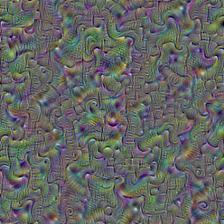

In [92]:
# Visualizing the blank image, img_noise which is defined above
img_noise = np.random.uniform(low=0.0, high=1.0, size=(1024,768,3)) * 256
render_deepdream(tf.square(T('mixed5b')), iter_n=30, octave_n=8, octave_scale=0.9)

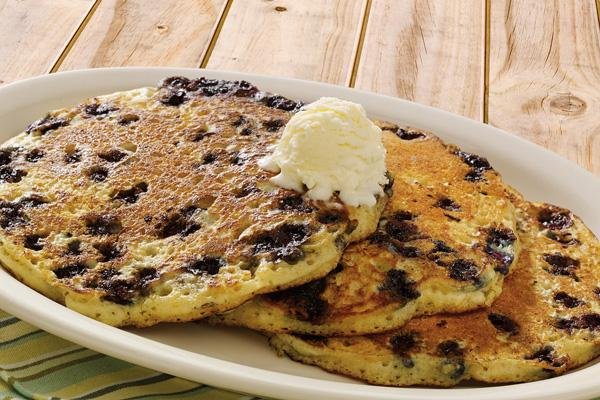

In [63]:
img0 = PIL.Image.open('images/pancakes.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

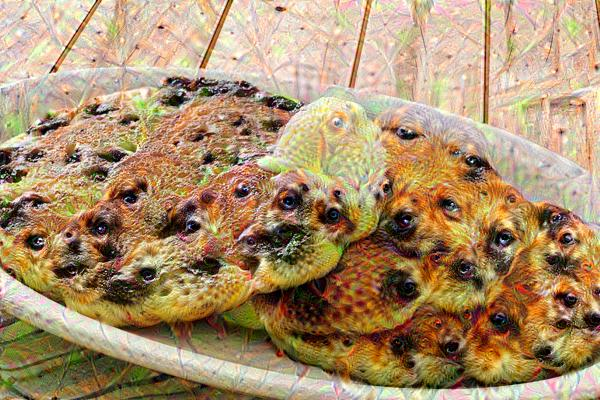

In [101]:
render_deepdream(tf.square(T('head0_bottleneck_pre_relu')), img0=img0, iter_n=20, step=1.5, octave_n=4, octave_scale=1.4)